# Unscented Kalman Filter: Highway Analysis

This Jupyter notebook will analyse the Unscented Kalman Filter (UKF) computations of a single test run.

To capture a test run of the highway scene, start the simulation with the `--log` flag to write the console or a CVS file:

`$ ukf_highway.exe --log [ukf_log.csv]`

### Read log file

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("ukf_log.csv", skiprows=0);
#df = pd.read_csv("ukf_log_lidar.csv", skiprows=0);
#df = pd.read_csv("ukf_log_radar.csv", skiprows=0);
df.describe()

,t,dt,lidar_x,lidar_y,nis_lidar,radar_r,radar_phi,radar_dr,nis_radar,x_px,x_py,x_v,x_yaw_angle,x_yaw_rate
count,1800.000000,1800.000000,900.000000,900.000000,9.000000e+02,900.000000,900.000000,900.000000,900.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,4.983333,0.016611,11.028594,0.082844,2.274802e+00,15.099658,0.169115,1.048436,3.673922,11.019924,0.074620,2.517688,0.001799,-0.002240
std,2.887538,0.016671,14.992218,3.242474,2.439928e+00,11.340907,1.429066,4.638671,3.212101,15.003971,3.233633,4.933205,0.175428,0.177912
min,0.000000,0.000000,-11.990600,-4.397130,1.084340e-311,3.383320,-2.526510,-6.583270,0.064318,-11.973300,-4.235320,-6.280250,-0.703862,-0.620030
25%,2.491668,0.000000,-1.954327,-3.901745,5.738053e-01,6.175270,-0.358653,-3.055137,1.494028,-1.993762,-3.965593,-1.373792,-0.032413,-0.041937
50%,4.983335,0.000000,9.705920,0.098356,1.461150e+00,11.254500,0.017045,0.847476,2.962255,9.595200,0.040658,4.739020,-0.002857,-0.000948
75%,7.475002,0.033333,20.877900,3.671457,3.116598e+00,21.046600,0.400764,5.405112,4.821915,20.895250,3.668740,5.967250,0.026613,0.034540
max,9.966670,0.033334,50.283900,4.359700,1.846510e+01,50.633800,3.210160,10.337200,37.875700,50.501700,4.099750,10.261400,0.499416,0.776645


In [2]:
df.head(4)

,name,t,dt,sensor_type,lidar_x,lidar_y,nis_lidar,radar_r,radar_phi,radar_dr,nis_radar,x_px,x_py,x_v,x_yaw_angle,x_yaw_rate
0,car1,0.0,0.0,lidar,-9.78791,3.78957,1.084340e-311,NaN,NaN,NaN,NaN,-9.78791,3.78957,0.00000,0.0,0.0
1,car1,0.0,0.0,radar,NaN,NaN,NaN,10.8145,2.725080,-4.31948,5.26377,-9.81409,3.89779,4.57926,0.0,0.0
2,car2,0.0,0.0,lidar,24.84540,-4.21043,1.084340e-311,NaN,NaN,NaN,NaN,24.84540,-4.21043,0.00000,0.0,0.0
3,car2,0.0,0.0,radar,NaN,NaN,NaN,25.3192,-0.190092,-5.61145,4.21659,24.86540,-4.23532,-5.63350,0.0,0.0


## Trace Plot

The following figure shows the trace of the lidar measurements (circles) vs. the prediction (line) for each named instance.

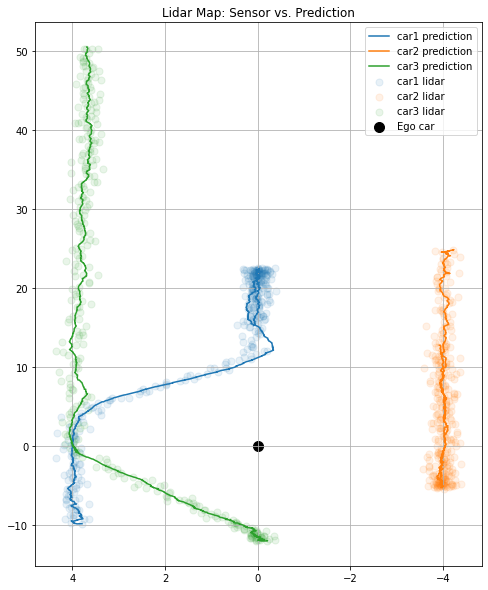

In [3]:
plt.figure(figsize=(8,10))
plt.title("Lidar Map: Sensor vs. Prediction")
for i, name in enumerate(np.unique(df.name)):
    df_i = df[df.name == name]
    c = plt.cm.tab10(i)
    plt.scatter(df_i.lidar_y, df_i.lidar_x, marker="o", s=50, color=c, alpha=0.1, label=f"{name} lidar")
    plt.plot(df_i.x_py, df_i.x_px, color=c, label=f"{name} prediction")    
plt.scatter([0],[0], marker="o", color="black", s=100, label="Ego car")
plt.gca().invert_xaxis()
plt.legend()
plt.grid()
plt.show();

<img src="https://video.udacity-data.com/topher/2019/April/5cb8ef7d_ukf-highway-projected/ukf-highway-projected.gif" width=500 align="left"/>

## Velocity Profiles

The following figure shown the corresponding speed profile of the 3 cars. Note: Speed is measured relative to the motion of the ego car.

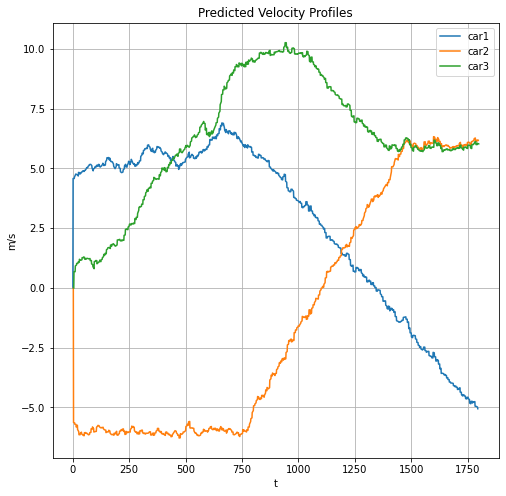

In [4]:
plt.figure(figsize=(8,8))
plt.title("Predicted Velocity Profiles")
for name in np.unique(df.name):
    plt.plot(df[df.name==name].x_v, label=name)
plt.xlabel("t")
plt.ylabel("m/s")
plt.grid()
plt.legend()
plt.show()

## Modelled Process Noise

Next we check the consistency of the selected process noise parameters.

The *Normalized Innovation Squared (NIS)* has been computed for the lidar and radar measurement, as introduced in the lesson [Parameters and Consistency](https://classroom.udacity.com/nanodegrees/nd313/parts/da5e72fc-972d-42ae-bb76-fca3d3b2db06/modules/a247c8c2-7d8c-4298-a3d9-a5eee48805cc/lessons/daf3dee8-7117-48e8-a27a-fc4769d2b954/concepts/f3ba9445-452d-4727-8209-b317d44ff1f1). It relates the difference between prediction and measurement $\Delta_{z}$ to the selected covariance matrix $S$ of the process noise.

NIS value $\epsilon = \Delta_{z}^T \cdot S^{-1} \cdot \Delta_{z}$ follows a $\chi^2$ distribution. To make sure that 95% of the time the prediction doesn't exceeds the expected process variance the NIS should be below the threshold of 6 (2D lidar measurements) or 7.82 (3D radar measurements) respectively.

This is checked in the following figures. Beside some spikes the NIS does not exceed the threshold, which means the deviation in the measurements doesn't exceed the modelled noise.

Compare this to the results of the filter consistency checks in the [lessons video](https://classroom.udacity.com/nanodegrees/nd313/parts/da5e72fc-972d-42ae-bb76-fca3d3b2db06/modules/a247c8c2-7d8c-4298-a3d9-a5eee48805cc/lessons/daf3dee8-7117-48e8-a27a-fc4769d2b954/concepts/b9251b43-1412-4c2b-8a0b-6ef3f1eb729a).

In [5]:
def plot_nis(series, name="radar", threshold=7.815):
    
    plt.figure(figsize=(12,6))
    title = f"$NIS_{{{name}}}(t)$"
    plt.title(title)
    plt.plot(series, label=f"NIS {name}")
    plt.hlines(threshold, xmin=0, xmax=len(df), color="red", label="95 %")
    plt.xlabel("t")
    plt.ylabel("NIS value")
    plt.legend()
    plt.grid()
    plt.show()

    plt.title(f"Histogram of $NIS_{{{name}}} values$")
    n,_,_ = plt.hist(series, cumulative=False, bins=30)
    plt.vlines(threshold, ymin=0, ymax=max(n), color="red")
    plt.xlabel("NIS value")
    plt.show()

### Radar

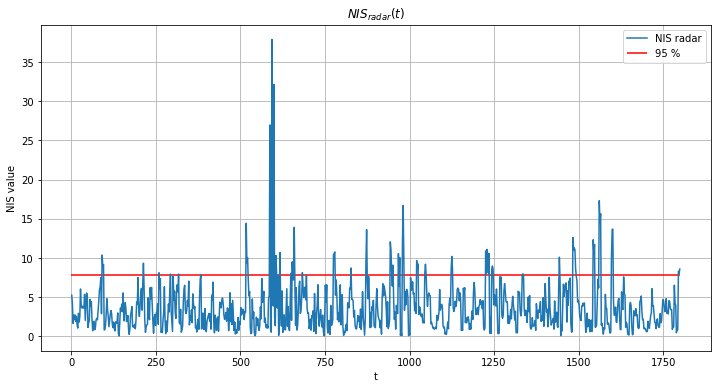

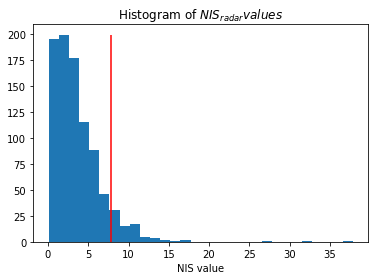

In [6]:
plot_nis(df[df.sensor_type=="radar"].nis_radar, "radar", 7.815)

### Lidar

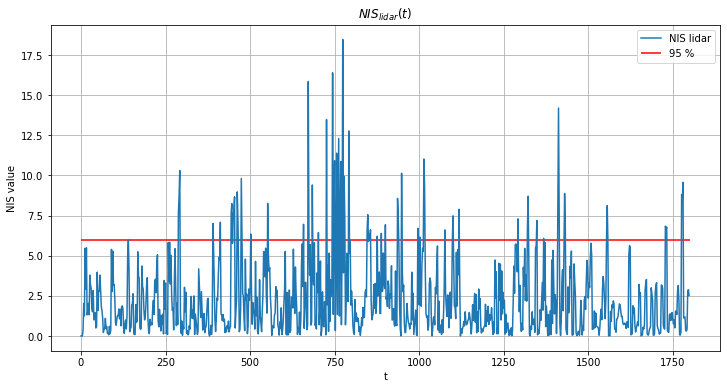

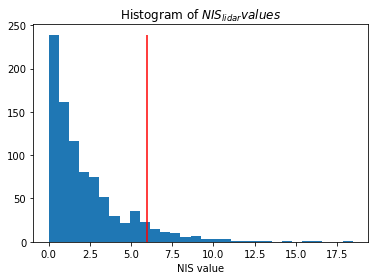

In [7]:
plot_nis(df[df.sensor_type=="lidar"].nis_lidar, "lidar", 6)